<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделение-данных" data-toc-modified-id="Разделение-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разделение данных</a></span></li><li><span><a href="#Функция-для-обучения-моделей" data-toc-modified-id="Функция-для-обучения-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Функция для обучения моделей</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, необходимо спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

import time

Загрузим и посмотрим данные

In [2]:
df = pd.read_csv(r'C:\Users\Anton\Desktop\YandexDisk\Practicum\мое\Оригинал\taxi.csv', parse_dates=[0], index_col=[0])
df.sort_index(inplace=True)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.index.is_monotonic_increasing

True

Данные индекса монотонно возрастают

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Видим временной ряд с 01.03.2018 до 31.08.2018

Посмотрим на исходный график

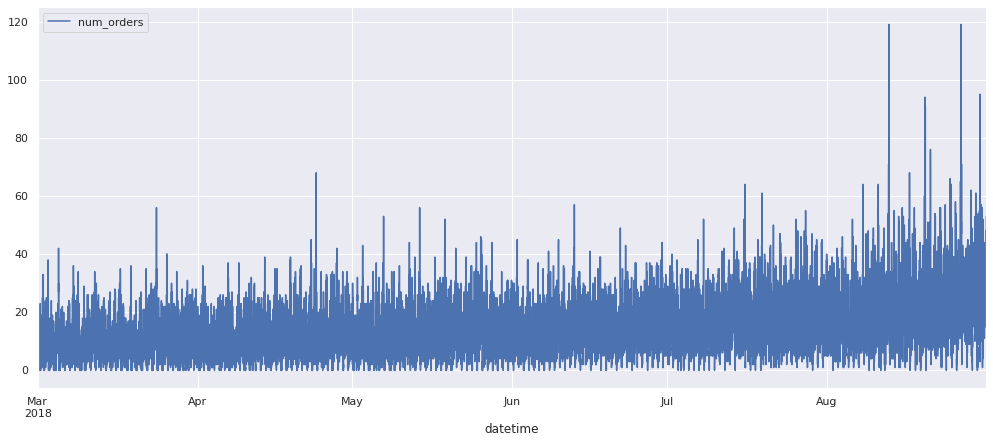

In [5]:
sns.set(rc={'figure.figsize':(17,7)})
df.plot();

## Анализ

Сделаем ресемплирование по часу и разложим график на составляющие

In [6]:
df = df.resample('1H').sum()

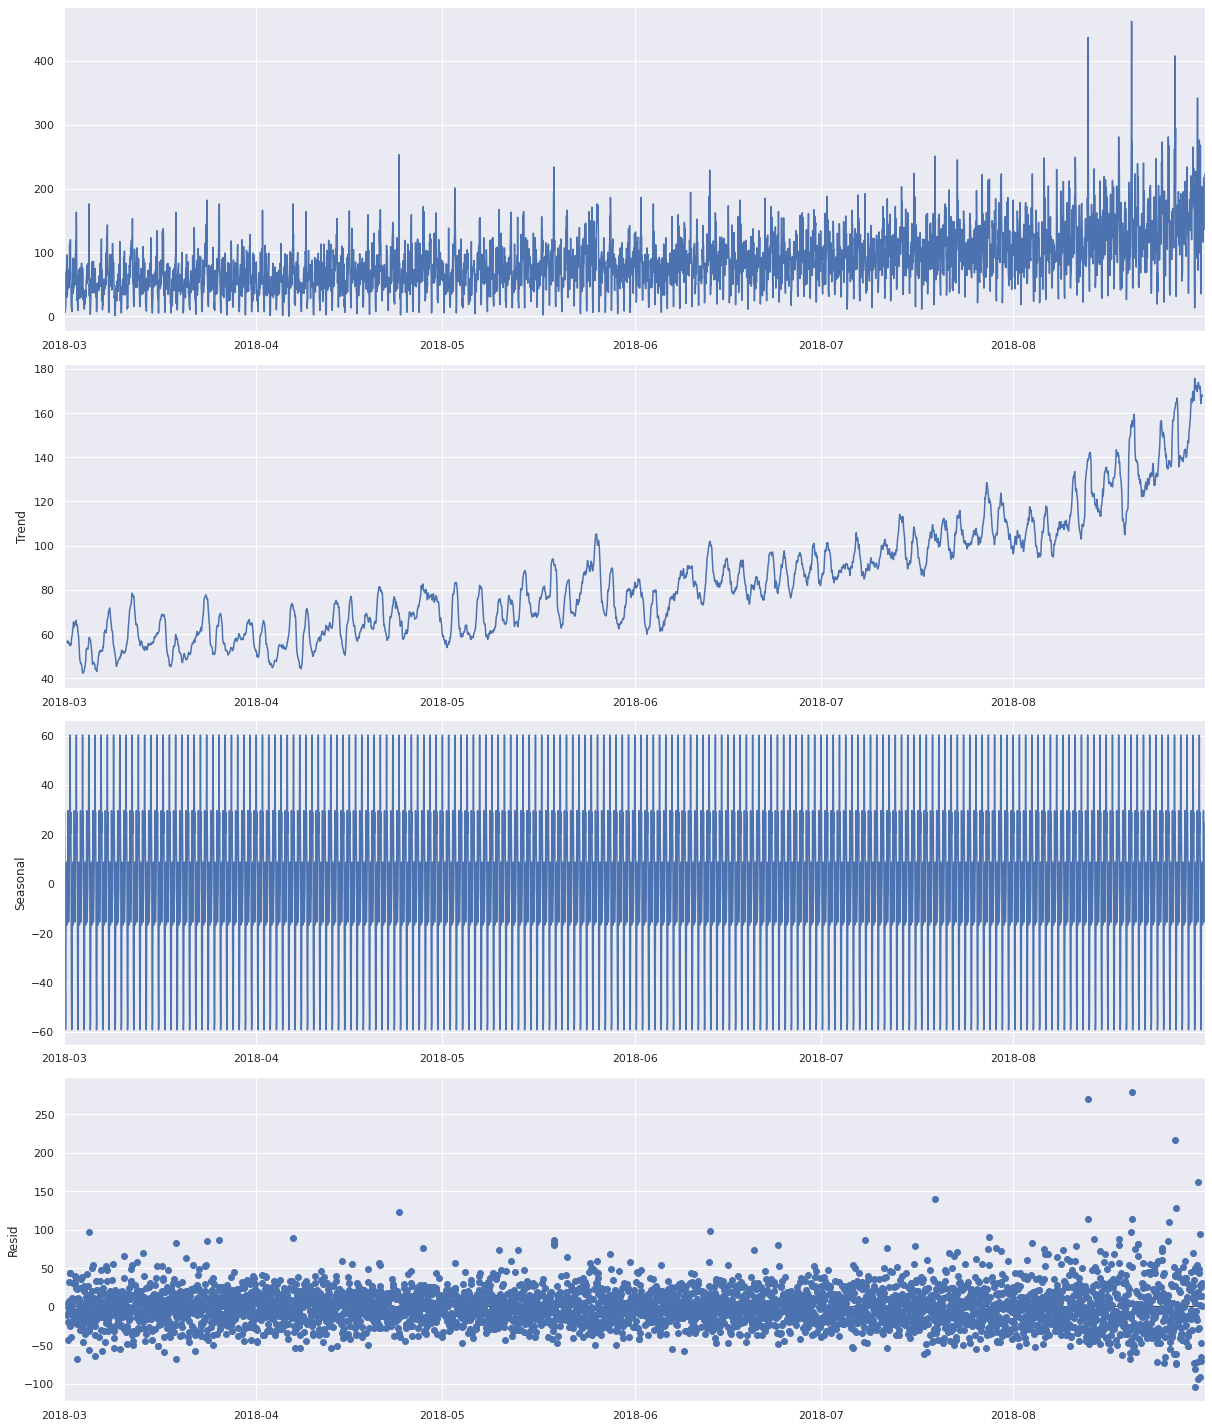

In [7]:
decompose = seasonal_decompose(df)

sns.set(rc={'figure.figsize':(17,20)})
decompose.plot()
plt.show()

Посмотрим на распределение заказов на случайной неделе

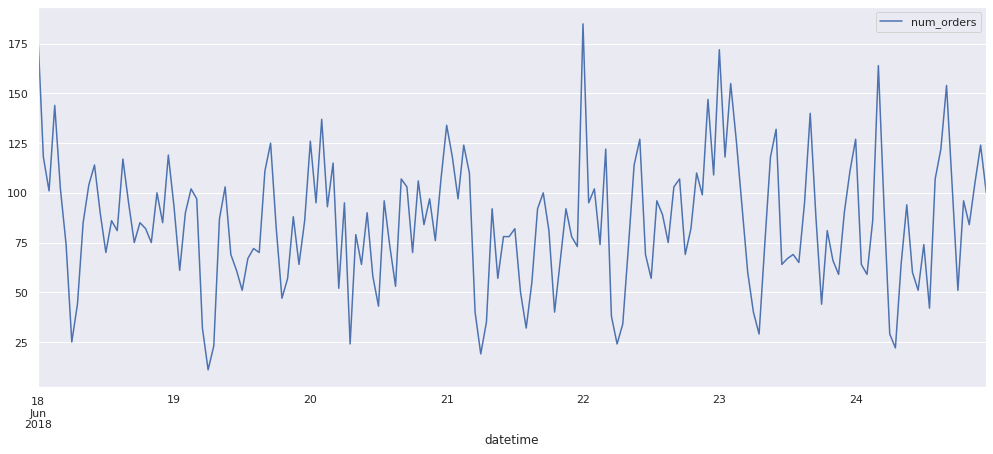

In [8]:
sns.set(rc={'figure.figsize':(17,7)})
df['2018-06-18':'2018-06-24 '].plot();

Также посмотрим медианные данные по неделе на всем датафрейме, для этого сгруппируем данные по дню недели

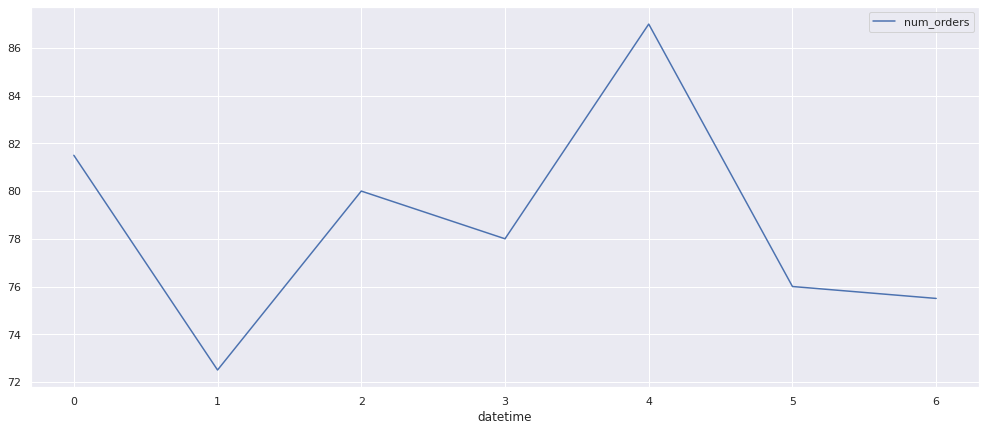

In [9]:
df.groupby(df.index.dayofweek).median().plot();

Виден определенный тренд, скорее всего такси развивается и количество пользователей растет. Также видна 'недельная' сезонность, спады на выходных и пики на рабочей неделе. Видно что понедельник и пятница лидируют по числу заказов.

Посмотрим на корреляцию относительно лагов (задержек во времени временного ряда)

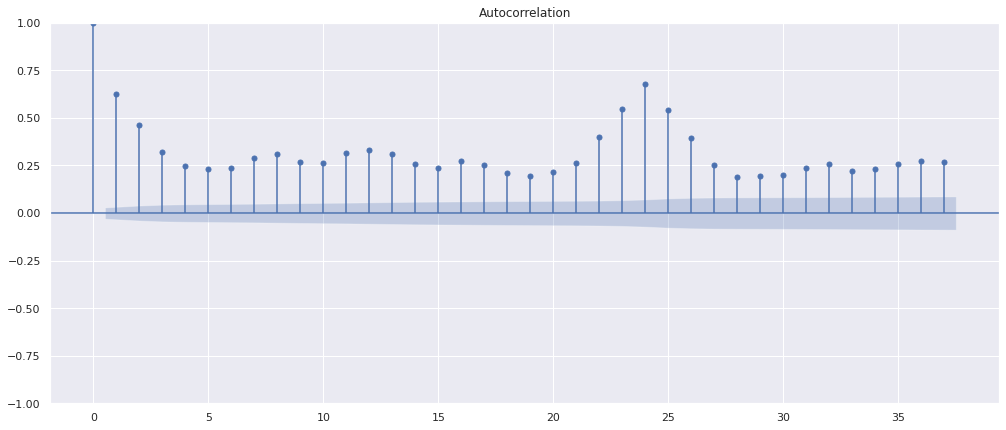

In [10]:
plot_acf(df)
plt.show()

Видим наибольшую корреляцию на лагах 1, 2, 8, 12, 24, добавим далее их в данные как признаки для обучения. 24 лаг показывает нам выраженную сезонность (в сутках 24 часа).

Напишем функцию для добавления признаков , на которых будем обучать модель(день недели, месяц, час, лаги, скользящие средние).

In [11]:
# Функция принимает на вход данные, список лагов, список размера окна скользящего среднего

def add_features(data, lag_list, rolling_mean_list):
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    data['hour'] = data.index.hour

    for i in lag_list:
        data[f'lag_{i}'] = data.iloc[:, 0].shift(i)
    
    for i in rolling_mean_list:
        # используем дополнительно сдвиг на 1час, так как мы не можем использовать текущие значения целевой велечины
        data[f'rolling_mean_{i}'] = data.iloc[:, 0].shift(1).rolling(i).mean()
        
    return data

<div class="alert alert-block alert-info">
<b>Совет: </b> Желательно было написать функцию таким образом, чтобы она возвращала новый датафрейм, а не изменяла глобальную переменную.
</div>

Добавим признаки, на которых будем обучать модель (день недели, месяц, час, список лагов, список размера окна скользящего среднего)

In [12]:
df = add_features(df, [1, 2, 8, 12, 24], [3, 7])

Удалим пропуски

In [13]:
df.dropna(inplace=True)
df.head()

,num_orders,dayofweek,month,hour,lag_1,lag_2,lag_8,lag_12,lag_24,rolling_mean_3,rolling_mean_7
datetime,,,,,,,,,,,
2018-03-02 00:00:00,90,4,3,0,58.0,113.0,43.0,30.0,124.0,79.000000,65.714286
2018-03-02 01:00:00,120,4,3,1,90.0,58.0,44.0,32.0,85.0,87.000000,72.285714
2018-03-02 02:00:00,75,4,3,2,120.0,90.0,73.0,48.0,71.0,89.333333,79.000000
2018-03-02 03:00:00,64,4,3,3,75.0,120.0,45.0,66.0,66.0,95.000000,83.285714
2018-03-02 04:00:00,20,4,3,4,64.0,75.0,61.0,43.0,43.0,86.333333,83.714286


## Обучение

### Разделение данных

Разделим данные на обучающую, валидационную и тестовую выборки

In [14]:
x = df.drop('num_orders', axis=1)
y = df['num_orders']

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

print(f'Размер обучающей выборки {x_train.shape} {y_train.shape}, \
     \nтестовой {x_test.shape} {y_test.shape}')

Размер обучающей выборки (3952, 10) (3952,),      
тестовой (440, 10) (440,)


In [16]:
del x, y, df

### Функция для обучения моделей

Напишем функцию для обучения моделей

In [17]:
list_of_results = pd.DataFrame(index=['Время обучения', 'Время предсказания', 'RMSE'])

In [18]:
def learning_model(model, X, Y, grid_param=None):
        
    global list_of_results
    list = []
    name_model = type(model).__name__
    tscv = TimeSeriesSplit(n_splits=3)
    
    model = GridSearchCV(model, grid_param, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1)
    
    timer = time.time()
    model.fit(X, Y)
    print('GridSearchCV подбирал параметры %.2f секунд' %(time.time() - timer))
    
    results = pd.DataFrame(model.cv_results_)
    
    # Добавим в список время обучения
    list.append(results.query('mean_test_score.idxmax()')['mean_fit_time'])
    print('Время обучения модели %.2f секунд' %results.query('mean_test_score.idxmax()')['mean_fit_time'])
    
    # Добавим в список время предсказания
    list.append(results.query('mean_test_score.idxmax()')['mean_score_time'])
    print('Модель предсказывает за %.2f секунд' %results.query('mean_test_score.idxmax()')['mean_score_time'])
    
    # Добавим в список RMSE, умножаем на -1 т.к. GridSearch выдает отрицательное значение
    list.append(-1 * model.best_score_)
    
    print('Наилучшее RMSE', -1 * model.best_score_)
    print('Лучшие параметры', model.best_params_)
        
    list_of_results[name_model] = list
    
    return model.best_estimator_

### CatBoost

In [19]:
%%time


cat_model = CatBoostRegressor(loss_function='RMSE',
                              verbose=False,
                              )

# Создадим словарь параметров
grid = {'learning_rate': [0.05, 0.2],
        'depth': [2, 3, 5],
        #'l2_leaf_reg': [1, 5],
        'iterations' : [150, 200, 250]
       }

#Обучим модель и подберем наилучшие параметры в нашем диапазоне
cat_model = learning_model(cat_model, x_train, y_train, grid)

GridSearchCV подбирал параметры 31.50 секунд
Время обучения модели 0.53 секунд
Модель предсказывает за 0.00 секунд
Наилучшее RMSE 25.279949591642335
Лучшие параметры {'depth': 3, 'iterations': 200, 'learning_rate': 0.2}
CPU times: user 8.29 s, sys: 805 ms, total: 9.09 s
Wall time: 31.5 s


### LGBMRegressor

In [20]:
%%time

lgbm_model = LGBMRegressor(n_jobs=-1)

# Создадим словарь параметров
grid = {"n_estimators": [150, 200, 250],
        "max_depth": [2, 3, 5]
        }

#Обучим модель и подберем наилучшие параметры в нашем диапазоне
lgbm_model = learning_model(lgbm_model, x_train, y_train, grid)

GridSearchCV подбирал параметры 13.27 секунд
Время обучения модели 0.33 секунд
Модель предсказывает за 0.03 секунд
Наилучшее RMSE 25.65227622232405
Лучшие параметры {'max_depth': 3, 'n_estimators': 200}
CPU times: user 13 s, sys: 121 ms, total: 13.1 s
Wall time: 13.3 s


### RandomForestRegressor

In [21]:
%%time

forest_model = RandomForestRegressor(random_state=1, n_jobs=-1)

# Создадим словарь параметров
grid = {"n_estimators": [150, 200, 250],
        "max_depth": [2, 3, 5]
        }

#Обучим модель и подберем наилучшие параметры в нашем диапазоне
forest_model = learning_model(forest_model, x_train, y_train, grid)

GridSearchCV подбирал параметры 17.58 секунд
Время обучения модели 0.75 секунд
Модель предсказывает за 0.02 секунд
Наилучшее RMSE 27.66392361102559
Лучшие параметры {'max_depth': 5, 'n_estimators': 200}
CPU times: user 17.4 s, sys: 129 ms, total: 17.6 s
Wall time: 17.6 s


На обучающей выборке модели показали следующие результаты

In [22]:
list_of_results

,CatBoostRegressor,LGBMRegressor,RandomForestRegressor
Время обучения,0.532573,0.330960,0.751796
Время предсказания,0.002003,0.033623,0.021468
RMSE,25.279950,25.652276,27.663924


CatBoostRegressor и LGBMRegressor схожи по метрикам (CatBoostRegressor немного превосходит по RMSE). Выберем лучшей моделью (при схожих гиперпараметрах) CatBoostRegressor.

## Тестирование

Протестируем лучшую модель на тестовой выборке

In [23]:
pred = cat_model.predict(x_test)
rmse = mean_squared_error(y_test, pred, squared=False)
    
list_of_results.loc['RMSE_test', 'CatBoostRegressor'] = rmse

Итоги

In [24]:
list_of_results

,CatBoostRegressor,LGBMRegressor,RandomForestRegressor
Время обучения,0.532573,0.330960,0.751796
Время предсказания,0.002003,0.033623,0.021468
RMSE,25.279950,25.652276,27.663924
RMSE_test,44.530424,NaN,NaN


Посмотрим на график предсказания

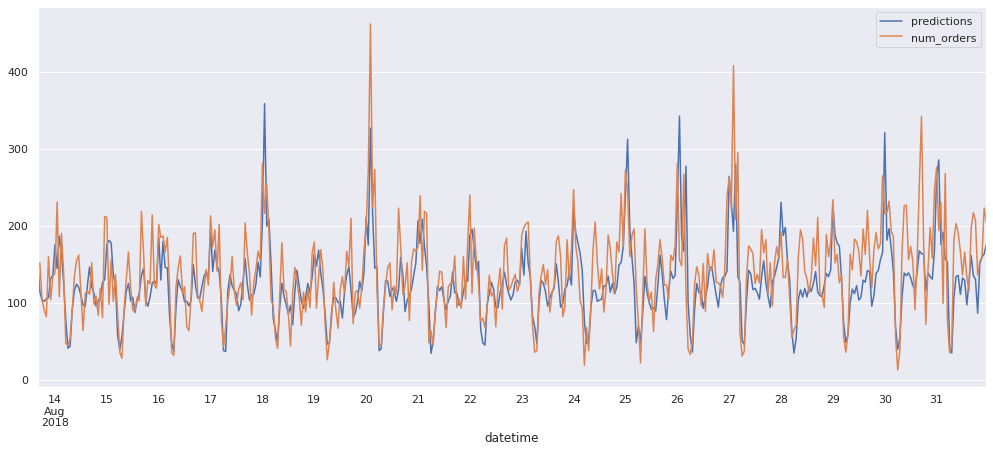

In [25]:
test = pd.DataFrame(pred, index=x_test.index, columns=['predictions'])
test.join(y_test).plot();

Посмотрим на важность признаков

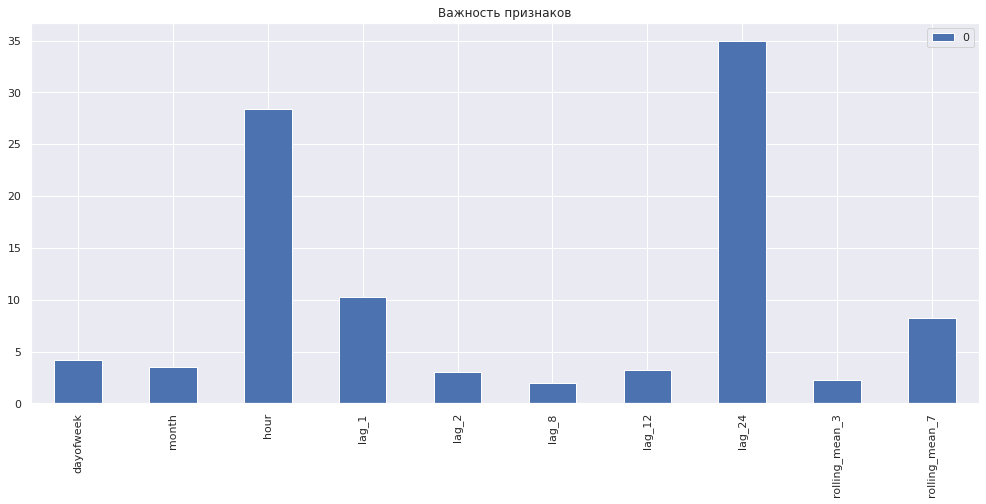

In [26]:
pd.DataFrame(cat_model.feature_importances_, x_train.columns).plot(kind='bar');
plt.title('Важность признаков');

## Вывод

- Был выполнен анализ и подготовка данных, в ходе которой были добавлены необходимые дополнительные признаки для обучения моделей.
- Было проведено сравнение моделей градиентного бустинга CatBoost, LightGBM и случайного леса.
- Были подобраны наилучшие параметры для моделей.
- CatBoostRegressor - лучшая модель. CatBoostRegressor и LGBMRegressor схожи по метрикам (CatBoostRegressor немного превосходит по RMSE).
- Самыми важными добавленными признаками являются время (час) и лаг 24 часа. 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48